# Latihan-3c Elastic Logs Review (Vp-Vs)

Latihan ini fokus terhadap review dan modifikasi Vp-Vs menggunakan hubungan empiris dan alurkerja iterasi Greenberg-Castagna. Prediksi Vs dilakukan dalam dua tahap untuk multimineral rocks dengan constituents utama sand-shale (klastik). Diskusi karbonat dapat dilakukan tetapi latihan untuk karbonat lebih lanjut dilakukan pada kelas lain.
<br><br> _citation for this page: "Adi Widyantoro, 2021, Pertamina Seismic QI Course, # Latihan-3c Elastic Logs Review (Vp-Vs).ipynb, accessed MM DD, YYYY."_  
<br>
>(update terakhir tanggal 1 Juli 2021 oleh Adi Widyantoro)
<hr>

__Tahap-1__ 
<br> Tetap menggunakan pre-built libraries dasar seperti numpy, matplotlib dan pandas. Sehingga kita tidak perlu membuat semua fungsi yang kita perlukan dari awal/scratch
<br> 
        
        special notes_: brugeslibrary adalah kumpulan pre-defined functions oleh Agile Geoscience bruges:
        https://github.com/agile-geoscience/bruges
        
        The bruges library's credits go to contributors: Evan Bianco, Ben Bougher, Matt Hall, Alessandro Amato del Monte, 
        Wes Hamlyn, Sean Ross-Ross

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import linregress
from f03elastic import elastic_sect, linerbackus
from brugeslibrary import backus
import matplotlib.colors as colors

__Tahap-2__
<br>Sama dengan Latihan-2, menggunakan file lokal atau yang tersimpan online untuk analisis. File path untuk lokal perlu diperhatikan dan diperbaiki jika perlu, menggunakan full path e.g. "C:/Users/Guest/Documents/python/well02logs.csv". Kemudian fungsi selanjutnya melakukan modifikasi header, pengaturan kolom, dan operasi lain, jika memang diperlukan agar mudah dibaca sebagai input analisis berikutnya. Menambahkan marker dari tabel untuk pembuatan zonasi. Karena jumlahnya yang sedikit, maka penambahan marker dapat juga menggunakan array secara manual
<br><br>_catatan_: library pandas (pd) dapat menggunakan tipe file lain seperti excel dengan command pd.read_excel('well02logs.xlsx'). Kemudian atribut fungsi reading file tersebut dapat dipelajari pada website pandas

In [2]:
# adi2=pd.read_csv('/content/adi02logs.csv') #jika menggunakan google colab' local
adi02=pd.read_csv('adi02logs.csv', warn_bad_lines=True, index_col=0)
adi02.rename(columns={'Depth_m':'Depth', 'Vp_km/s':'Vp', 'Vs_km/s':'Vs','GammaRay_api':'GR',
                      'Density_g/cc':'Rho','Caliper_m':'Cal','Swt_v/v':'Swt','Phit_v/v':'Phit', 
                      'Vsh_v/v':'Vsh'}, inplace=True)

In [3]:
# adi02tops=pd.read_csv('/content/adi02markers.csv') #jika menggunakan google colab' local
adi02tops=pd.read_csv('adi02markers.csv')
adi02tops.rename(columns={'Tops':'marker','Depth_m':'markerdep'}, inplace=True)
marker=np.array(adi02tops['marker'])
markerdep=np.array(adi02tops['markerdep'])
#print(adi02tops, " ", sep='\n')
#printmarker=marker.transpose()
#printmarkerdep=markerdep.transpose()

__Tahap-3__

#### Diskusi khusus : Backus Averaging untuk menghilangkan atau mengurangi spikes dan outliers

Menggunakan fungsi backus averaging dari bruges library. Catatan dari bruges mengenai fungsi backus, sbb:
    
    Backus averaging. Using Liner's algorithm (2014):
    input:
        vp (ndarray): P-wave interval velocity.
        vs (ndarray): S-wave interval velocity.
        rho (ndarray): Bulk density.
        lb (float): The Backus averaging length in m.
        dz (float): The depth sample interval in m.
    output:
        The smoothed logs vp, vs, rho. Useful for computing other elastic parameters at a seismic scale.
    Reference:
        Liner, C (2014), Long-wave elastic attenuation produced by horizontal layering. 
        The Leading Edge, June 2014, p 634-638.

In [4]:
logs=adi02
z=logs.index
vp0=logs.Vp # log original
vs0=logs.Vs # log original
rho0=logs.Rho # log original
length=50
sample=10
vpba,vsba,rhoba=backus(vp0, vs0, rho0, length, sample) # menjalankan fungsi backus bruges dg penjelasan di atas
vpfilt=np.zeros(np.shape(vp0))
vsfilt=np.zeros(np.shape(vs0))
rhofilt=np.zeros(np.shape(rho0))
logs['Vpfilt']=np.round(vpba,2); logs['Vsfilt']=np.round(vsba,2); logs['Rhofilt']=np.round(rhoba,2)
#with pd.option_context('expand_frame_repr', False):
#    print(logs.head(2))
exec(open('f03plotbackus.py').read())

## Greenberg-Castagna Vp-Vs (shear velocity)

__Tahap-4__
<br> Hubungan empiris Greenberg and Castagna (1992) memberikan hubungan Vp-Vs dalam kerangka multimineral dan brine saturated rocks berdasarkan hubungan polinomial
<br>Ref: _(The Rock Physics handbook, 2nd ed., p375)_

Untuk pure constituent litologi, hubungan empiris Vs dari Vp (dalam km/s):

<font size=4>${V_s} = {a_{i2}}{V_p^2} + {a_{i1}}{V_p} + {a_{i0}}$</font>

Untuk campuran litologi, menggunakan kerangka Voigt-Reuss-Hill average (dalam km/s):

<font size=4>${V_s} = 0.5 * ( ({\sum_{i=0}^{L}{X_i}}{\sum_{j=0}^{N_i}{a_{ij}}{\alpha_C^j}}) +  ({\sum_{i=0}^{L}{X_i}}({\sum_{j=0}^{N_i}{a_{ij}}{\alpha_C^j}})^{-1})^{-1} )$</font>

$X_i$ adalah lithology fraction, dan ${\sum_{i=0}^{L}{X_i}}=1$


|Litho     |ai2  |ai1   |ai0   |
|:-        |---- |----: |:--:  |
|shale     |0    |0.769 |-0.867|
|sandstone |0    |0.804 |-0.855|
|limestone |-0.055|1.016|-1.030|
|dolomite  |0    |0.583 |-0.077|

Hubungan average Vp-Vs dengan tabel empiris di atas (Castagna, 1993) dilakukan dalam konteks batuan berisi fluida brine 100%. Estimasi mixture fluida dilakukan melalui iterasi menggunakan poin Vp,Vs {brine} terhadap insitu mixture melalui iterasi, sbb:
1. mulai dengan initial guess Vp{brine_guess} dari Vp{log}
2. menghitung Vs{brine} dari Vp{brine_guess} menggunakan regresi empiris di atas
3. melakukan substitusi fluida dari pasangan Vp,Vs{brine} menjadi Vp,Vs{fluid} melalui Gassmann
4. hasil perhitungan Vs{fluida} dan Vp{log}, gunakan Gassmann untuk menghitung estimasi Vp{brine_new} baru.
5. lakukan analisis minimasi error = Vp{brine_new} - Vp{brine_guess}. Kriteria konvergensi adalah error minimum yang dapat ditentukan. Jika kriteria tercapai maka iterasi dihentikan, jika tidak maka kembali ke langkah no.2


Contoh step-by-step mixture dengan constituent utama klastik: Sand dan Shale. Setiap step dapat didiskusikan dalam kelas
<br>

    dari sebelumnya telah dibuat 2 litofasies
    sh shales 1
    sd sand   2
    diperlukan br brine 3

In [5]:
# reinisialisasi dataframe
pd.options.mode.chained_assignment = None
top_plot=1650
base_plot=1800
worklogs=logs[(logs.index >= top_plot) & (logs.index <= base_plot)]
shale=0.65; sand=0.45; pay=0.9; phi=0.05; rho=1.8
#litho
clsd=((worklogs.Vsh <= sand) & (worklogs.Phit >= phi))
#clsd=((worklogs.Vsh <= sand) & (worklogs.Rho <= rho))
mfssh=((worklogs.Vsh >= shale) & (worklogs.Swt == 1.0))
fflag=np.zeros(np.shape(worklogs.Vsh))
fflag[mfssh.values]=1
fflag[clsd.values]=2
#fluid
br=((clsd) & (worklogs.Swt == 1.0))
oil=((clsd) & (worklogs.Swt <= pay))
fflag[br.values]=3
fflag[oil.values]=4
worklogs['fflag']=fflag
dfsh=worklogs.loc[worklogs['fflag'] == 1]
dfsd=worklogs.loc[worklogs['fflag'] == 2]
dfbr=worklogs.loc[worklogs['fflag'] == 3]
dfoil=worklogs.loc[worklogs['fflag'] == 4]
dfbr.head(2); #remove semi colon

In [6]:
phiavg=dfoil.Phit.mean().round(3); vshavg=dfoil.Vsh.mean().round(3) #untuk future reference
phiavg, vshavg

(0.207, 0.195)

### Langkah-1 mixture monomineralic sand dan shale menggunakan hubungan polynomial Castagna

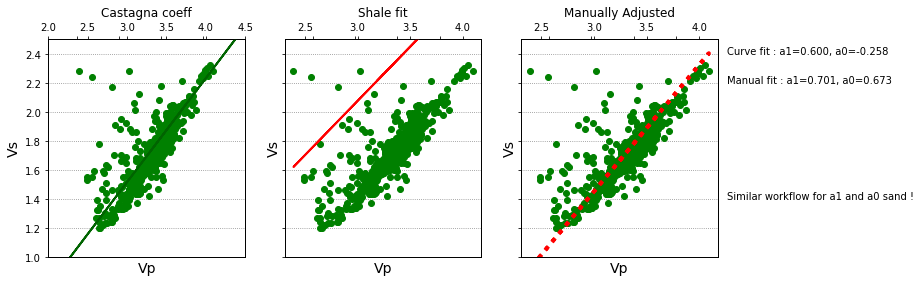

In [7]:
#--------------------------------------------SHALE FITTING----------------------------------------------------------
dff=worklogs; z=dff.index; zsh=dfsh.index
vpall=dff['Vpfilt']; vsall=dff['Vsfilt']
vpsh=dfsh['Vpfilt']; vssh=dfsh['Vsfilt']
def gcsdsh(vp, a1, a0):
    return (a1*vp - a0)
#castagna coeff
a1sh=0.769; a0sh=0.867; a1sd=0.804; a0sd=0.855
vs_shgc = np.zeros(np.shape(vpall))
vs_shgc = gcsdsh(vpall, a1sh, a0sh)
vs_sdgc = np.zeros(np.shape(vpall))
vs_sdgc = gcsdsh(vpall, a1sd, a0sd)
#------------ data fitting options (no ML)---------------
# OPTION-1 curve fitting
#a1sh, pcov = curve_fit(gcsdsh,vpsh, vssh)
#a1_sh=a1sh[0].round(2); a0_sh=a1sh[1].round(2)
#vs_shfit=gcsdsh(vpall, a1_sh, a0_sh)
#OPTION-2 poly fitting option with deg=1 or ax+b format
#a1_sh, a0_sh = np.polyfit(vpsh, vssh, 1)
#vs_shfit=gcsdsh(vpall, a1_sh, a0_sh)
#OPTION-3 linear regression scipy
linregsh = stats.linregress(vpsh, vssh)
a1_sh=linregsh[0]; a0_sh=linregsh[1]
vs_shfit=gcsdsh(vpall, a1_sh, a0_sh)
#OPTION-4 numpy linear matrix solution for least square
#vpsharr = np.vstack([vpsh, np.ones(len(vpsh))]).T
#a1_sh, a0_sh = np.linalg.lstsq(vpsharr, vssh, rcond=None)[0]
#vs_shfit=gcsdsh(vpall, a1_sh, a0_sh)
#--------------------------------------------------------
# manual
a1shm=0.701; a0shm=0.673
vs_shman=gcsdsh(vpall, a1shm, a0shm)
# QC plot for shale
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
for bb in axs:
    bb.set_xticks([]); bb.set_xlabel("Vp", size=14)
    bb.grid(color='grey', linestyle=':')
    bb.set_ylabel("Vs", size=14)
ax11 = axs[0].twiny(); ax11.plot(vpsh, vssh, 'go')
ax11.set_title('Castagna coeff', size=12);
ax11.set_ylim([1, 2.5]); ax11.set_xlim([2.0, 4.5])
ax12 = axs[0].twiny(); ax12.plot(vpall, vs_shgc,'darkgreen', lw=2)
ax21 = axs[1].twiny(); ax21.plot(vpsh, vssh, 'go')
ax21.set_title('Shale fit', size=12)
ax22 = axs[1].twiny(); ax22.plot(vpall, vs_shfit,'red', lw=2)
ax31 = axs[2].twiny(); ax31.plot(vpsh, vssh, 'go')
ax31.set_title('Manually Adjusted', size=12)
ax32 = axs[2].twiny(); ax32.plot(vpall, vs_shman,'red', linestyle=":",lw=4)
for cc in [ax12, ax22, ax32]:
    cc.xaxis.set_ticklabels([])
autosh=f"Curve fit : a1={a1_sh:.3f}, a0={a0_sh:.3f}"
autosd=f"Manual fit : a1={a1shm:.3f}, a0={a0shm:.3f}"
plt.text(4.6,2.4,autosh,color='k', size=10);
plt.text(4.6,2.2,autosd,color='k', size=10);
plt.text(4.6,1.4,"Similar workflow for a1 and a0 sand !",color='k', size=10);
plt.show()

Sand plot dengan Castagna coefficients

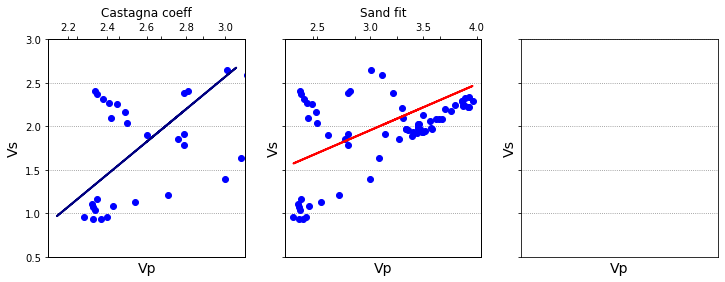

In [8]:
#------------------SAND FITTING----------------------------------------------------------
vpbr=dfbr['Vpfilt']; vsbr=dfbr['Vsfilt']
vpoil=dfoil['Vpfilt']; vsoil=dfoil['Vsfilt']
#------------ data fitting options (no ML)---------------
# OPTION-1 curve fitting
a1br, pcov = curve_fit(gcsdsh,vpbr, vsbr)
a1_br=a1br[0].round(2); a0_br=a1br[1].round(2)
vs_brfit=gcsdsh(vpall, a1_br, a0_br)
#OPTION-2 poly fitting option with deg=1 or ax+b format
#a1_br, a0_br = np.polyfit(vpbr, vsbr, 1)
#vs_brfit=gcsdsh(vpall, a1_br, a0_br)
#OPTION-3 linear regression scipy
#linregbr = stats.linregress(vpbr, vsbr)
#a1_br=linregbr[0]; a0_br=linregbr[1]
#vs_brfit=gcsdsh(vpall, a1_br, a0_br)
#OPTION-4 numpy linear matrix solution for least square
#vpbrarr = np.vstack([vpbr, np.ones(len(vpbr))]).T
#a1_br, a0_br = np.linalg.lstsq(vpbrarr, vsbr, rcond=None)[0]
#vs_brfit=gcsdsh(vpall, a1_br, a0_br)
#--------------------------------------------------------
# QC plot for sand
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
for bb in axs:
    bb.set_xticks([]); bb.set_xlabel("Vp", size=14)
    bb.grid(color='grey', linestyle=':')
    bb.set_ylabel("Vs", size=14)
ax11 = axs[0].twiny(); ax11.plot(vpbr, vsbr, 'bo')
ax11.set_title('Castagna coeff', size=12)
ax11.set_ylim([0.5, 3]); ax11.set_xlim([2.1, 3.1])
ax12 = axs[0].twiny(); ax12.plot(vpall, vs_sdgc,'navy', lw=2)
ax21 = axs[1].twiny(); ax21.plot(vpbr, vsbr,'bo')
ax21.set_title('Sand fit', size=12)
ax22 = axs[1].twiny(); ax22.plot(vpall, vs_brfit,'red', lw=2)
for cc in [ax12, ax22]:
    cc.xaxis.set_ticklabels([])
plt.show()

# HOMEWORK

Latihan dapat dilanjutkan dengan melakukan fitting dan plotting pada data sand points di atas.
<br><br> Gunakan pilihan salahsatu cara di bawah atau temukan cara sendiri untuk membatasi interval gassmann, kemudian plot overlay hasilnya dibandingkan dengan gambar di atas,... _good luck !_

#### QC hasil fitting terhadap log

In [9]:
# QC Coefficient Fitting
# input
dfvs=worklogs
vplog = dfvs.Vp.values
vslog = dfvs.Vs.values
rholog = dfvs.Rho.values
vshlog = dfvs.Vsh.values
phitlog = dfvs.Phit.values
swtlog = dfvs.Swt.values
z = dfvs.index.values
def vs2litho(vsh, phi, vp, a1sh, a0sh, a1sd, a0sd):
    vsd = np.zeros(np.shape(vsh))
    vsd = 1 - vsh - phi
    shfrac = vsh/(vsh+vsd)
    sdfrac  = vsd/(vsh+vsd)
    vs_shm = np.zeros(np.shape(vp))
    vs_shm = a1sh*vp + (-a0sh)
    vs_sdm = np.zeros(np.shape(vp))
    vs_sdm = a1sd*vp + (-a0sd)
    vsreuss = 1/((shfrac/vs_shm) + (sdfrac/vs_sdm))
    vsvoigt = (vs_shm*shfrac + vs_sdm*sdfrac)
    vsgc = 0.5 * (vsreuss + vsvoigt)
    return vsgc

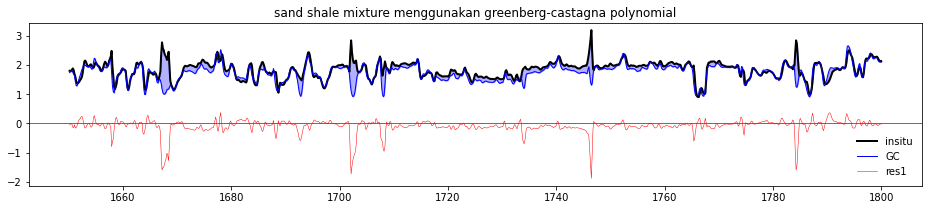

rata rata residual:-0.098


In [10]:
# original Castagna
vsgc1=vs2litho(vshlog,phitlog,vplog, a1sh, a0sh, a1sd, a0sd)
res1=vsgc1-vslog
plt.figure(figsize=(16,3))
plt.title("sand shale mixture menggunakan greenberg-castagna polynomial"); 
plt.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
plt.plot(z,vslog, 'k', lw=2, label="insitu"); plt.plot(z, vsgc1, 'b', lw=1, label="GC")
plt.plot(z,res1, 'r', lw=0.5, label="res1")
plt.axhline(0, color='r', lw=0.8)
plt.fill_between(z, vsgc1, vslog, color='blue', alpha=0.3)
plt.legend(loc="lower right",frameon=False, fontsize=10); plt.show()
avgres1=res1.mean().round(3)
print('rata rata residual:%.3f'% avgres1)

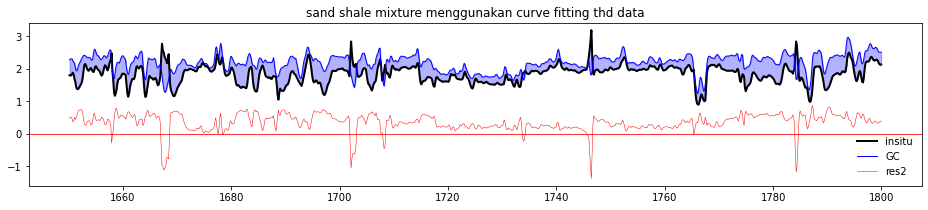

rata rata residual:0.346


In [11]:
# curve fitting
a1_br=0.8; a0_br=0.6   # placeholder untuk latihan sand fitting
vsgc2=vs2litho(vshlog,phitlog,vplog, a1_sh, a0_sh, a1_br, a0_br)
res2=vsgc2-vslog
plt.figure(figsize=(16,3))
plt.title("sand shale mixture menggunakan curve fitting thd data"); 
plt.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
plt.plot(z,vslog, 'k', lw=2, label="insitu"); plt.plot(z, vsgc2, 'b', lw=1, label="GC")
plt.plot(z,res2, 'r', lw=0.5, label="res2")
plt.axhline(0, color='r', lw=0.8)
plt.fill_between(z, vsgc2, vslog, color='blue', alpha=0.3)
plt.legend(loc="lower right",frameon=False,fontsize=10); plt.show()
avgres2=res2.mean().round(3)
print('rata rata residual:%.3f'% avgres2)

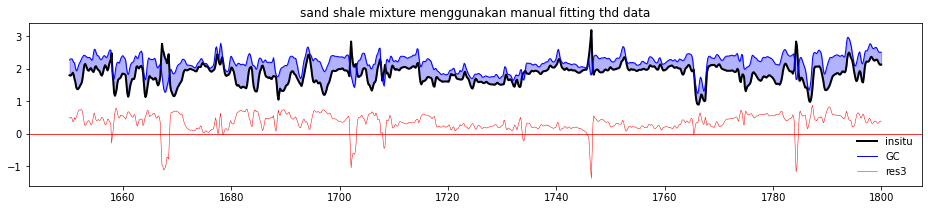

rata rata residual:-0.238


In [12]:
# manual fitting
a1brm=0.6; a0brm=0.5   # placeholder untuk latihan sand fitting
vsgc3=vs2litho(vshlog,phitlog,vplog, a1shm, a0shm, a1brm, a0brm) # sand coeff sama dengan Caastagna
res3=vsgc3-vslog
plt.figure(figsize=(16,3))
plt.title("sand shale mixture menggunakan manual fitting thd data"); 
plt.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
plt.plot(z,vslog, 'k', lw=2, label="insitu"); plt.plot(z, vsgc2, 'b', lw=1, label="GC")
plt.plot(z,res2, 'r', lw=0.5, label="res3")
plt.axhline(0, color='r', lw=0.8)
plt.fill_between(z, vsgc2, vslog, color='blue', alpha=0.3)
plt.legend(loc="lower right",frameon=False, fontsize=10); plt.show()
avgres3=res3.mean().round(3)
print('rata rata residual:%.3f'% avgres3)

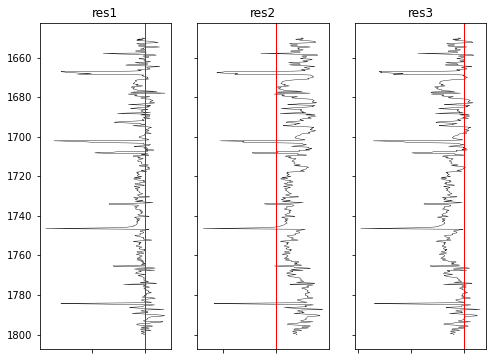

In [13]:
# perbandingan error atau residual vs depth
fig, axs = plt.subplots(ncols=3, figsize=(8,6), sharey=True)
ax1 = axs[0]; ax1.plot(res1, z, 'k', lw=0.4, label="res1");ax1.set_title("res1") 
ax2 = axs[1];ax2.plot(res2, z, 'k', lw=0.4, label="res2");ax2.set_title("res2") 
ax3 = axs[2];ax3.plot(res3, z, 'k', lw=0.4, label="res3");ax3.set_title("res3")
for aa in axs:
    aa.xaxis.set_ticklabels([])
    aa.axvline(0, color='r', lw=1)
    aa.invert_yaxis()
plt.show()

### challenges: 
1) pelajari dan gunakan teknik error minimization e.g. terhadap rms error<br>
2) pelajari dan gunakan Machine Learning (scikit.learn) untuk mencari a1 and a0 dan proses meminimumkan error

### Langkah-2 iterasi hidrokarbon interval menggunakan Gassmann

In [14]:
#recall input
vplog = worklogs.Vpfilt.values
vslog = worklogs.Vsfilt.values
rholog = worklogs.Rhofilt.values
vshlog = worklogs.Vsh.values
phitlog = worklogs.Phit.values
swtlog = worklogs.Swt.values
z = worklogs.index.values
vplogbrine=dfbr.Vpfilt.values

## Bound Theories: Reuss, Voigt, Voigt-Reuss-Hill(VRH)

In [15]:
# -----------fungsi-fungsi yang akan dipakai berkali-kali dalam iterasi----------------
# castagna's constants
a1sh=0.769
a0sh=0.867
a1sd=0.804
a0sd=0.855
# Volume Fraction
def vs2litho(vsh, phi, vp, a1sh, a0sh, a1sd, a0sd):
    vsd = np.zeros(np.shape(vsh))
    vsd = 1 - vsh - phi
    shfrac = vsh/(vsh+vsd)
    sdfrac  = vsd/(vsh+vsd)
    vs_shm = np.zeros(np.shape(vp))
    vs_shm = a1sh*vp + (-a0sh)
    vs_sdm = np.zeros(np.shape(vp))
    vs_sdm = a1sd*vp + (-a0sd)
    vsreuss = 1/((shfrac/vs_shm) + (sdfrac/vs_sdm))
    vsvoigt = (vs_shm*shfrac + vs_sdm*sdfrac)
    vs_ssd = 0.5 * (vsreuss + vsvoigt)
    return vs_ssd

def mix2litho(vsh, phi, mod_sh, mod_qz):
    vsd = np.zeros(np.shape(vsh))
    vsd = 1 - vsh - phi
    shfrac = vsh/(vsh+vsd)
    sdfrac  = vsd/(vsh+vsd)
    modreuss = 1/((shfrac/mod_sh) + (sdfrac/mod_qz))
    modvoigt = (mod_sh*shfrac + mod_qz*sdfrac)
    modvrh = 0.5 * (modreuss + modvoigt)
    return modvrh

def mix2any(f1, k1, k2):
    f2 = 1 - f1
    kreuss = 1/((f1/k1) + (f2/k2))
    kvoigt = (f1*k1 + f2*k2)
    kvrh = 0.5*(kreuss + kvoigt)
    return kreuss,kvoigt,kvrh # 0: reuss, 1: voigt; 2: vrh

In [16]:
# fluid and mineral common values
rho_qz=2.65;  k_qz=36.6;  mu_qz=44    # mineral properties, quartz (i.e., sands)
rho_sh=2.58;  k_sh=20.9;  mu_sh=5     # mineral properties, clay (i.e., shales)
rho_br=1.09;   k_br=2.8               # fluid properties, brine
rho_oil=0.78;   k_oil=0.94              # fluid properties, oil
rho_gas=0.25;   k_gas=0.06              # fluid properties, gas

In [17]:
# Initial vp brine guess (SEED POINT)
guess = np.random.uniform(0.001, 0.1)
vguess = (1 + guess) * vplog
print(guess)

0.07187212126015495


In [18]:
# Vs brine dari initial Vp brine menggunakan simplifikasi polynomial Greenberg-Castagna utk 2 lithology
a1sh=0.701; a0sh=0.673; a1sd=0.602; a0sd=0.625 # array-1
#a1sh=0.769; a0sh=0.867; a1sd=0.804; a0sd=0.855 # array-2
vsgc=vs2litho(vshlog,phitlog,vplog, a1sh, a0sh, a1sd, a0sd)

## Langkah Gassmann

In [19]:
# input: Vp brine guess, Vs brine; output: Vs fluid
def stepgasmn(vp1, vs1, vplog, vslog, rho_sh, rho_qz, k_sh, k_qz, rho_fl1, rho_fl2, k_fl1, k_fl2, phi, vsh, swt):
    rho_ma=vsh*(rho_sh)+(1-vsh)*rho_qz                    # STEP-01 rho_ma
    rho1 = (1-phi)*rho_ma + (phi*rho_fl1)                 # rho1 atau rho brine,i.e.fl1
    mu1 = rho1*vs1**2                                     # dapat dihitung mu baik dari rholog maupun rho_br
    k1 = rho1*vp1**2-(4/3)*mu1                            # dari mu1 bisa dihitung k1, brine
    #insitu properties------------------------
    kmixma=mix2any(vsh, k_sh, k_qz); k_ma=kmixma[2]       # k_ma 0: reuss, 1:voigt, 2: vrh
    kfl=1/((swt/k_fl1+((1-swtlog)/k_fl2)))                # menggunakan insitu, swt log
    rho_fl=swtlog*rho_fl1+(1-swtlog)*rho_fl2
    rho_sat=(phi*rho_fl)+((1-phi)*rho_ma)
    ksat=rho_sat*((vplog**2)-((4/3)*mu1))
    #kdry------------------------
    upper_kdry=k1*((phi*k_ma)/ksat+(1-phi))-k_ma
    lower_kdry=(phi*k_ma)/ksat+(k1/k_ma)-1-phi
    kdry=upper_kdry/lower_kdry                            # STEP-02 hitung Kdry
    #replacement------------------------
    upper_k2=(1-(kdry/k_ma))**2                           # hitung Kfluid2
    lower_k2=(phi/ksat)+((1-phi)/k_ma)-(kdry/k_ma**2)
    k2=kdry+(upper_k2/lower_k2)
    #elastic properties------------------------
    rho2 = np.zeros(np.shape(vp1))                        # STEP-03 output vp2, vs2, rho2
    vp2 = np.zeros(np.shape(vp1))
    vs2 = np.zeros(np.shape(vp1))
    rho2 = (1-phi)*rho_ma + (phi*rho_fl1)
    vp2 = np.sqrt(((k2+(4/3)*mu1))/rho2)
    vs2 = np.sqrt((mu1/rho2))
    return vp2, vs2                                       # output penting estimasi Vs dengan some unknown fluid

In [20]:
# insitu properties dengan asumsi swtlog, philog, dan brine-oil mixture
iterate=stepgasmn(vguess, vsgc, vplog, vslog, rho_sh, rho_qz, k_sh, k_qz, 
                rho_br, rho_oil, k_br, k_oil, phitlog, vshlog, swtlog)
vpbrinew=iterate[0]; vsnew=iterate[1];
vpdiff=(vpbrinew-vplog).round(3)
vsdiff=(vsnew-vslog).round(3)
print(vpdiff.mean(), vsdiff.mean())

0.23769817073170732 -0.2817560975609756


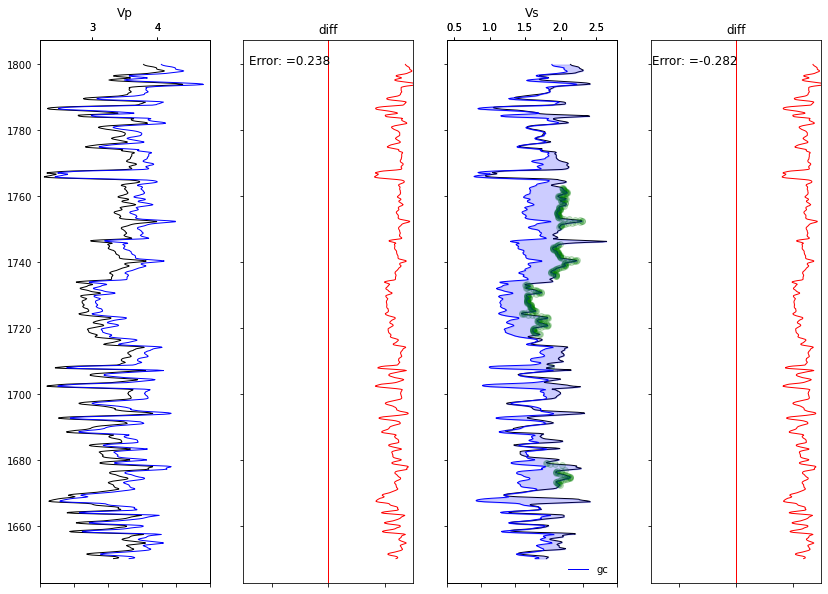

In [21]:
dfoilz=dfoil.index.values 
dfoilvp=dfoil.Vpfilt.values; dfoilvs=dfoil.Vsfilt.values
# QC Error
fig, axs = plt.subplots(ncols=4, figsize=(14,10), sharey=True)
ax1 = axs[0].twiny(); ax1.plot(vplog, z, 'k', lw=1, label="log"); 
ax1.set_title("Vp"); ax1.set_xlim(2.2,4.8)
ax2 = axs[0].twiny(); ax2.plot(vpbrinew, z, 'b', lw=1, label="gc")
ax2.set_xlim(2.2,4.8)
ax3 = axs[1]; ax3.plot(vpdiff, z, 'r', lw=1, label="diff")
ax3.set_title("diff"); ax3.axvline(0, color='r', lw=1)
ax4 = axs[2].twiny(); ax4.set_xlim(0.4,2.8)
ax4.plot(vslog, z, 'k', lw=1, label="log")
ax4.plot(dfoilvs, dfoilz, 'go', alpha=0.2)
ax4.set_title("Vs"); ax5 = axs[2].twiny()
ax5.plot(vsnew, z, 'b', lw=1, label="gc"); ax5.set_xlim(0.4,2.8)
ax5.fill_betweenx(z, vsnew, vslog, color='blue', alpha=0.2)
ax6 = axs[3]; ax6.plot(vpdiff, z, 'r', lw=1, label="diff")
ax6.set_title("diff"); ax6.axvline(0, color='r', lw=1)
for aa in axs:
    aa.invert_yaxis()
    aa.xaxis.set_ticklabels([])
for ab in [ax3, ax6]:
    ab.set_xlim(-0.3,0.3)
textvp=f"Error: ={vpdiff.mean():.3f}"
textvs=f"Error: ={vsdiff.mean():.3f}"
plt.text(-2.4,1800,textvp,color='k', size=12);
plt.text(3.3,1800,textvs,color='k', size=12);
plt.legend(loc="lower right",frameon=False,fontsize=10)
plt.show()

Contoh iterasi atau looping berikut - untuk diskusi dalam kelas dan project untuk dikembangkan lebih lanjut

In [22]:
# test ksat iterations
k1=2.8;   k2=0.94
def ksatiteration(f1, k1, k2):
    f2 = 1 - f1
    k_reuss = 1/((f1/k1) + (f2/k2))
    k_voigt = (f1*k1 + f2*k2)
    k_vrh = 0.5*(k_reuss + k_voigt)
    return (k_vrh)
f1 = 5
for i in range(f1):
    ksat = ksatiteration(0.1*i, k1, k2)
print(ksat)

1.482077821011673


parameter yang dapat dioptimisasi atau meminimumkan error: <br>
__castagna coefficients, guess seed point, k_fluid mixture, rho_sat berdasarkan fluid mixture__, dsb.

scipy documentation mempunyai banyak deskripsi mengenai fungsi minimisasi: <br> https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html<br>
https://scipy-lectures.org/advanced/mathematical_optimization/

<h1><center>-Akhir Program Latihan-3c-<center></h1>